In [1]:
#%matplotlib inline
import gudhi as gd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
# import pandas as pd
# import scipy
import pickle
# import scipy.sparse as sp


from pygenstability import run, constructors, plotting
from pygenstability.contrib.optimal_scales import *

In [3]:
import sys
from pathlib import Path
module_path = str(Path.cwd().parents[2] / "Software/Mobility Data Code/src")
if module_path not in sys.path:
    sys.path.append(module_path)

from partitioning import *

# Generate SBM

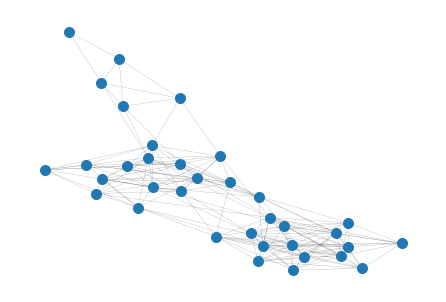

In [4]:
# set a simple SBM model
# sizes = [15, 35, 25]
sizes = [15, 5, 15]
probs = [[0.7, 0.08, 0.10], [0.08, 0.8, 0.02], [0.10, 0.02, 0.80]]

H = nx.stochastic_block_model(sizes, probs, seed=0)

# need to set the weights to 1
for i, j in H.edges():
    H[i][j]["weight"] = 1
    
# # Transform to directed
# H = H.to_directed()

# # Get adjacency matrix
# A1 = nx.adjacency_matrix(H).toarray()
# # Get rid of self-loops
# A_H = A1 - np.diag(np.diag(A1))

# # Create graph
# A_H = sp.csr_matrix(A_H)
# H = nx.DiGraph(A_H)

# Draw
pos_H = nx.layout.spring_layout(H,seed=1)
nx.draw(H,pos_H,node_size = 100, width = 0.1)

In [5]:
# Compute adjacency etc.
H_1 = H
pos_1 = nx.layout.spring_layout(H_1,seed=1)
A_1 = nx.adjacency_matrix(H_1)
n_nodes = len(H_1.nodes())

In [6]:
def create_sbm():
    """simple test"""
    # set a simple SBM model
    sizes = [20, 35, 25, 20, 30, 35]
    probs = [[0.70, 0.08, 0.10, 0.01, 0.02, 0.00], 
             [0.08, 0.8,  0.06, 0.02, 0.00, 0.00], 
             [0.10, 0.06, 0.80, 0.00, 0.01, 0.02],
             [0.01, 0.02, 0.00, 0.70, 0.08, 0.10], 
             [0.02, 0.00, 0.01, 0.08, 0.80, 0.06], 
             [0.00, 0.00, 0.02, 0.10, 0.06, 0.80]]
    probs = np.asarray(probs)

    graph = nx.stochastic_block_model(sizes, probs, seed=0)

    # need to set the weights to 1
    for i, j in graph.edges():
        graph[i][j]["weight"] = 1

    # ground truth
    community_labels = [graph.nodes[i]["block"] for i in graph]

    # spring layout
    pos = nx.spring_layout(graph, weight=None, scale=1)
    for u in graph:
        graph.nodes[u]["pos"] = pos[u]

    # draw the graph with ground truth
    plt.figure(figsize=(10,8))
    nx.draw(graph, pos=pos, node_color=community_labels)
    plt.title("Ground truth communities")
    plt.savefig("ground_truth.png", bbox_inches="tight")

    # save adjacency with pickle
    adjacency =  nx.adjacency_matrix(graph, weight="weight")
    with open("sbm_graph.pkl", "wb") as pickle_file:
        pickle.dump(adjacency, pickle_file)

    # save .gpickle for community plotting
    nx.write_gpickle(graph, "sbm_graph.gpickle")

    # save with text file as alternative format
    edges = pd.DataFrame()
    edges["i"] = [e[0] for e in graph.edges] + [e[1] for e in graph.edges]
    edges["j"] = [e[1] for e in graph.edges] + [e[0] for e in graph.edges]
    edges["weight"] = 2 * [graph.edges[e]["weight"] for e in graph.edges]
    edges.to_csv("edges.csv", index=False)

    return graph, pos, adjacency

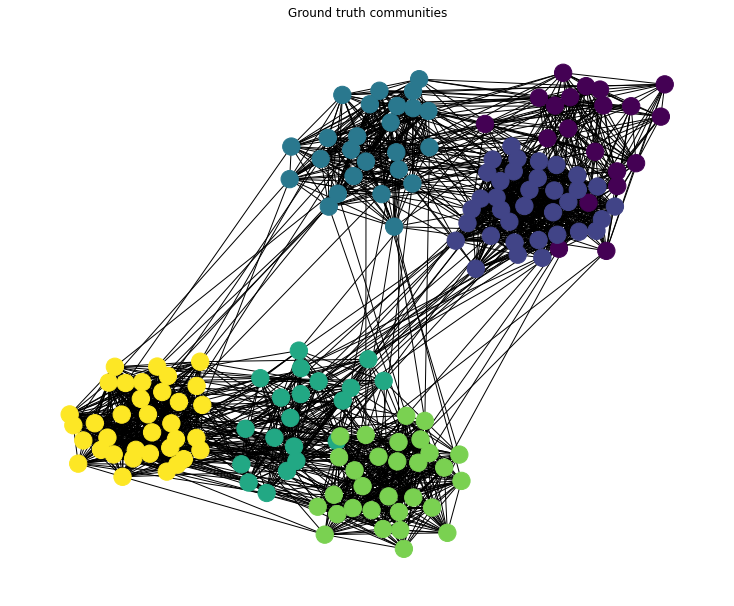

In [7]:
H_2, pos_2, A_2 = create_sbm()

# Markov Stability analysis on SBM model


In [8]:
graph = H_2
pos = pos_2
adj = A_2


In [9]:
# Set parameters
n_time = 30
min_time = -2
max_time = 1

100%|██████████| 30/30 [00:01<00:00, 15.91it/s]


UnboundLocalError: local variable 'ax4' referenced before assignment

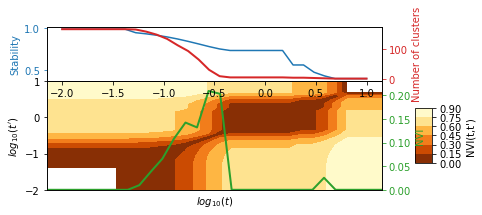

In [10]:
all_results = run(adj, constructor='continuous_normalized', 
min_time=min_time,max_time=max_time,n_time=n_time)

plotting.plot_scan(all_results, use_plotly=False)

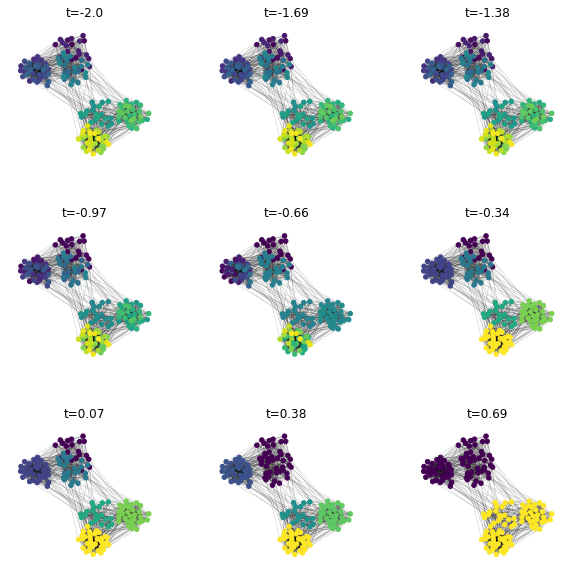

In [ ]:
# Get times
times = all_results['times']
log_times = np.log10(all_results['times'])

# Get information about communities
community_id = all_results['community_id']
n_communities  = all_results['number_of_communities']

# fig, axes = plt.subplots(3, 3, figsize=(10,10))
# fig.subplots_adjust(hspace=0.4, wspace=0.3)

# for i, ax in enumerate(axes.flat):
    
#     time = 3*i+1
    
#     # Compute sizes of each community
#     labels_graph_counts = np.histogram(community_id[time],bins=np.arange(0,n_communities[time]+1)) [0]


#     # Plot community sizes as barplot
#     ax.bar(np.arange(0,n_communities[time]),labels_graph_counts)
#     # Label barplot
#     ax.set(ylabel = 'Community size' ,
#            title = 't={}'.format(np.around(np.log10(times[time]),2)),
#            xlabel='Community')
# plt.show()

fig, axes = plt.subplots(3, 3, figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes.flat):
    
    time = int(i*len(times)/9)
    
    nx.draw(graph, ax=ax,pos=pos, node_size = 20, arrows=False, width = 0.1,
            node_color = community_id[time])
    ax.set(title=r't={}'.format(np.around(np.log10(times[time]),2)))
plt.show()

[-1.48275862 -0.03448276]
(30,) (30,)


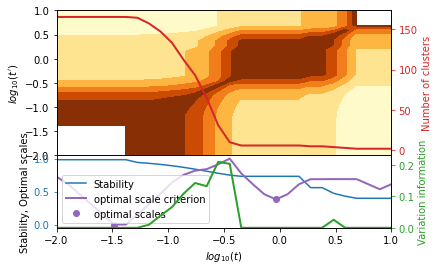

In [ ]:
identify_optimal_scales(all_results,criterion_threshold=0)
selected_scales = log_times[all_results['selected_partitions']]
print(selected_scales)
plot_optimal_scales(all_results)
plt.show()

# Markov Stability Filtration

Simplex Trees: 
- https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-simplex-Trees.ipynb
- https://gudhi.inria.fr/python/latest/simplex_tree_ref.html
- https://gudhi.inria.fr/python/latest/persistence_graphical_tools_ref.html

In [51]:
community_ids = all_results['community_id']

In [52]:
st = gd.SimplexTree()

As soon as the dimension of the simplices get too high (over 35), the kernel dies.

In [65]:
for i in range(len(log_times)):
    for c in node_id_to_dict(graph,community_ids[i]).values():

        # if len(c)<35:
        #     st.insert(list(c),filtration = log_times[i])


        # Only add small faces 
        for face in itertools.combinations(c, 5):
            st.insert(list(face),filtration = log_times[i])
        
       

In [ ]:
# st_gen = st.get_filtration() 
# for splx in st_gen :
#     print(splx)

In [ ]:
st.dimension()

3

In [ ]:
st.num_vertices()

165

In [ ]:
st.num_simplices()

3794190

In [ ]:
# st.set_dimension(3)

In [ ]:
st.num_simplices()

3794190

# Persistant homology

In [ ]:
persistence = st.persistence()#persistence_dim_max=True)

In [ ]:
# st.persistence_pairs()

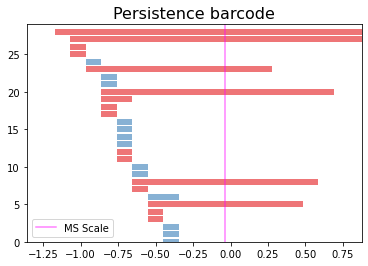

In [ ]:
ax = gd.plot_persistence_barcode(persistence)
for i in range(len(selected_scales)):
    if i == 0:
        ax.axvline(selected_scales[i],c='magenta',alpha=0.5,label='MS Scale')
    else:
        ax.axvline(selected_scales[i],c='magenta',alpha=0.5)
ax.legend()

plt.show()

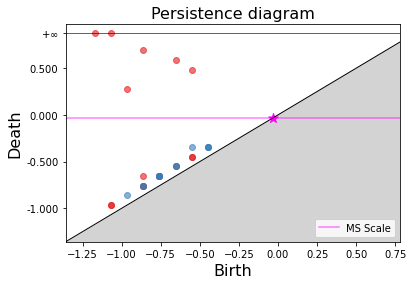

In [ ]:
ax = gd.plot_persistence_diagram(persistence)
for i in range(len(selected_scales)):
    if i == 0:
        ax.axhline(selected_scales[i],c='magenta',alpha=0.5,label='MS Scale')
    else:
        ax.axhline(selected_scales[i],c='magenta',alpha=0.5)

    ax.scatter(selected_scales[i],selected_scales[i],c='magenta',marker='*',s=100)

ax.legend()
plt.show()

So far so good but the results don't look very meaningful to me at the moment---at least when trying to relate persistent homology to the optimal scales. These are some plots for documentation where I marked the optimal scales in the persistence diagram/barcode. It also took very long to compute the persistence, 10 min for the very small network! Still, one observation could be that the interruptions between the red dots in the persistence diagram correspond to the bottoms of the NVI(t) but not sure if this is coincidental or about the meaning.

And to give you more context, the red dotes correspond to the connected components in the filtration and are deduced from 0th homology groups. It might mean that the red dots capture when two regions of the graph that belonged to different communities over several Markov scales finally merge.

The blue dotes correspond to one-dimensional "circular" holes (1st homology group) and the green ones to two-dimensional "voids" (2nd homology group). I am not sure about there meaning in this experiment. But the death of these dots also correlates with the plateau of the NVI(t,t') and minima of the NVI(t)

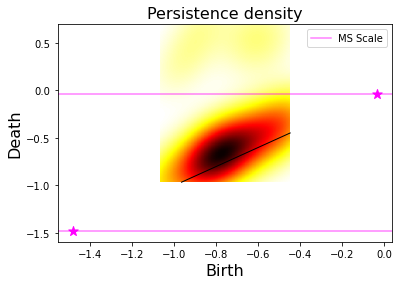

In [ ]:
ax = gd.plot_persistence_density(persistence)
for i in range(len(selected_scales)):
    if i == 0:
        ax.axhline(selected_scales[i],c='magenta',alpha=0.5,label='MS Scale')
    else:
        ax.axhline(selected_scales[i],c='magenta',alpha=0.5)

    ax.scatter(selected_scales[i],selected_scales[i],c='magenta',marker='*',s=100)

ax.legend()
plt.show()